In [1]:
# Change the following line if running locally
running_in_colab = True

# Configuration

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os

if running_in_colab:
    !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
    !chmod +x Miniconda3-latest-Linux-x86_64.sh
    !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
    !time conda install -q -y -c conda-forge rdkit openbabel
    
    !git clone https://github.com/gmum/MLinPL2019_cheminfo_workshops.git
    os.chdir('/content/MLinPL2019_cheminfo_workshops/notebooks/generative-models/release')
    sys.path.append('/usr/local/lib/python3.7/site-packages/')
    base_path = '/content/MLinPL2019_cheminfo_workshops/notebooks/generative-models'
else:
    os.chdir('release')
    base_path = '../'

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns

from torch.autograd import Variable
from tqdm import tqdm, trange
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import QED
from rdkit.Chem import Crippen

rdBase.DisableLog('rdApp.error')
# DrawingOptions.atomLabelFontSize = 50
# DrawingOptions.dotsPerAngstrom = 100
# DrawingOptions.bondLineWidth = 3

use_cuda = torch.cuda.is_available()

# Data Preparation

First, let's see what's in our data. Almost every generative model in drug design needs to learn a drug-like distribution of molecules before specific properties can be optimized. This can be achieved by downloading a big chunk of a chemical database, e.g. [Zinc](https://zinc.docking.org/) or [ChEMBL](https://www.ebi.ac.uk/chembl/). We'll use the latter, following the original [work](https://advances.sciencemag.org/content/4/7/eaap7885?intcmp=trendmd-adv) of Popova, Isayev, and Tropsha. The compounds in our dataset should be valid and synthesizable since only such compounds can be stored in this database (unless a mistake occured). Because we expect our molecules to be drug-like, all of them should have high [Quantitative Estimate of Druglikeness](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3524573/) (QED), and most of them should conform to Lipinski's rule of five:
- no more than 5 hydrogen bond donors,
- no more than 10 hydrogen bond acceptors,
- a molecular mass less than 500 daltons,
- an octanol-water partition coefficient (log P) that does not exceed 5.

## Exploratory Data Analysis

For a good start, we can look at a few molecules in the dataset and check their properties.

1. Load the data file, print a couple of SMILES strings, and plot random molecules.
2. Try to find information about one of the molecules using its ChEMBL id.
3. Calculate QED for a selected set of molecules (e.g. 1000 randomly chosen). Can you see the difference between ones with low and high QED?

In [7]:
data_path = f'{base_path}/data/chembl_22_clean_1576904_sorted_std_final.smi'

df = pd.read_csv(data_path, sep='\t', header=None)
display(df.sample(10))

def plot_random_molecules(smiles, legends=None, n_to_draw=9):
  ind = np.random.randint(0, len(smiles), n_to_draw)
  mols_to_draw = [Chem.MolFromSmiles(smiles[i]) for i in ind]
  if legends is not None:
    legends = [legends[i] for i in ind]

  return Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(300, 300),
                              legends=legends, useSVG=True)
  
plot_random_molecules(df[0], df[1])

## Data Generator

Below, there is a data generator that takes care of loading the data and storing the SMILES alphabet.

In [6]:
from data import GeneratorData 

tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

gen_data = GeneratorData(training_data_path=data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

# Modeling

Now, it is time to implement the generative component. Text data is often processed by recurrent neural networks (RNN) such as LSTM or GRU, and similarly we want to apply these architectures to SMILES strings. Unfortunately, the output often happens to be invalid in this case. ReLeaSE algorithm proposed by Popova et al. proves that this issue can be mitigated by using RNNs with a stack.

The grammar of SMILES strings is a context-free grammar, which means that some characters depend on their counterparts in the other part of a word (e.g. open and close parentheses). The stack helps the model remember about these dependencies.

For this part, try to:

1. implement a stack in the RNN module,
2. train the network for a few epochs and check if the network learns to produce valid SMILESes,
3. plot molecules corresponding to valid generated SMILESes,
3. (homework) compare the validity of SMILES when stack is used to the results of a bare RNN -- this may take some time.

## RNN with Stack

For the implementation you can use `TemplateRNN` class which takes care of variable initialization and implements all the needed method. What is missing is the `forward` method which should take an input, a hidden state, and the current stack and return the output, the updated hidden state and a new stack. For simplicity, you can assume that one-directional GRU will be used, which means there is no cell state as in the LSTM architecture. You should also use the following initialized class properties:

- `stack_input_layer` is a linear layer $(hidden\times width)$
- `stack_control_layer` is a linear layer $(hidden\times 3)$

Also, `stack` $\in \mathbb{R}_{1\times depth\times width}$ is initialized with zeros before each training step (parsing one SMILES). Implementation hints are included in the code. The new stack should be assembled in `stack_augmentation` method.

In [0]:
from stackRNN import TemplateRNN

class StackAugmentedRNN(TemplateRNN):

  def forward(self, inp, hidden, stack):
    """
    Forward step of the model. Generates probability of the next character
    given the prefix.

    Parameters
    ----------
    inp: torch.tensor
        input tensor that contains prefix string indices

    hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
        previous hidden state of the model. If layer_type is 'LSTM',
        then hidden is a tuple of hidden state and cell state, otherwise
        hidden is torch.tensor

    stack: torch.tensor
        previous state of the augmented memory stack

    Returns
    -------
    output: torch.tensor
        tensor with non-normalized probabilities of the next character

    next_hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
        next hidden state of the model. If layer_type is 'LSTM',
        then next_hidden is a tuple of hidden state and cell state,
        otherwise next_hidden is torch.tensor

    next_stack: torch.tensor
        next state of the augmented memory stack
    """
    inp = self.encoder(inp.view(1, -1))  # 1 x 1 x hidden
    if self.has_stack:
      # make probabilities over possible stack operations
      stack_controls = ...
      # prepare a new input to the stack
      stack_input = ...
      stack = self.stack_augmentation(stack_input.permute(1, 0, 2),
                                      stack, stack_controls)
      # make an input which takes into account the top of the stack
      inp = ...
    output, next_hidden = self.rnn(inp.view(1, 1, -1), hidden)  # 1 x 1 x hidden
    output = self.decoder(output.view(1, -1))  # 1 x n_tokens
    return output, next_hidden, stack

  def stack_augmentation(self, input_val, prev_stack, controls):
    """
    Augmentation of the tensor into the stack. For more details see
    https://arxiv.org/abs/1503.01007

    Parameters
    ----------
    input_val: torch.tensor
        tensor to be added to stack

    prev_stack: torch.tensor
        previous stack state

    controls: torch.tensor
        predicted probabilities for each operation in the stack, i.e
        PUSH, POP and NO_OP. Again, see https://arxiv.org/abs/1503.01007

    Returns
    -------
    new_stack: torch.tensor
        new stack state

    """
    controls = controls.view(-1, 3, 1, 1)
    a_push, a_pop, a_no_op = controls[:, 0], controls[:, 1], controls[:, 2]
    # create stacks with the new input pushed and the top popped
    stack_down = ...
    stack_up = ...
    # make a linear combination of the results of all stack operations
    new_stack = ...
    return new_stack

In [0]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.01
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [0]:
n_iterations = 3000
losses = my_generator.fit(gen_data, n_iterations)
plt.plot(losses)
my_generator.evaluate(gen_data)

### Solution

In [0]:
from stackRNN import TemplateRNN

class StackAugmentedRNN(TemplateRNN):

  def forward(self, inp, hidden, stack):
    """
    Forward step of the model. Generates probability of the next character
    given the prefix.

    Parameters
    ----------
    inp: torch.tensor
        input tensor that contains prefix string indices

    hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
        previous hidden state of the model. If layer_type is 'LSTM',
        then hidden is a tuple of hidden state and cell state, otherwise
        hidden is torch.tensor

    stack: torch.tensor
        previous state of the augmented memory stack

    Returns
    -------
    output: torch.tensor
        tensor with non-normalized probabilities of the next character

    next_hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
        next hidden state of the model. If layer_type is 'LSTM',
        then next_hidden is a tuple of hidden state and cell state,
        otherwise next_hidden is torch.tensor

    next_stack: torch.tensor
        next state of the augmented memory stack
    """
    inp = self.encoder(inp.view(1, -1))  # 1 x 1 x hidden
    if self.has_stack:
      if self.has_cell:
        hidden_ = hidden[0]
      else:
        hidden_ = hidden
      if self.is_bidirectional:
        hidden_2_stack = torch.cat((hidden_[0], hidden_[1]), dim=1)
      else:
        hidden_2_stack = hidden_.squeeze(0)
      stack_controls = self.stack_controls_layer(hidden_2_stack)
      stack_controls = F.softmax(stack_controls, dim=1)
      stack_input = self.stack_input_layer(hidden_2_stack.unsqueeze(0))
      stack_input = torch.tanh(stack_input)
      stack = self.stack_augmentation(stack_input.permute(1, 0, 2),
                                      stack, stack_controls)
      stack_top = stack[:, 0, :].unsqueeze(0)
      inp = torch.cat((inp, stack_top), dim=2)
    output, next_hidden = self.rnn(inp.view(1, 1, -1), hidden)  # 1 x 1 x hidden
    output = self.decoder(output.view(1, -1))  # 1 x n_tokens
    return output, next_hidden, stack

  def stack_augmentation(self, input_val, prev_stack, controls):
    """
    Augmentation of the tensor into the stack. For more details see
    https://arxiv.org/abs/1503.01007

    Parameters
    ----------
    input_val: torch.tensor
        tensor to be added to stack

    prev_stack: torch.tensor
        previous stack state

    controls: torch.tensor
        predicted probabilities for each operation in the stack, i.e
        PUSH, POP and NO_OP. Again, see https://arxiv.org/abs/1503.01007

    Returns
    -------
    new_stack: torch.tensor
        new stack state

    """
    batch_size = prev_stack.size(0)

    controls = controls.view(-1, 3, 1, 1)
    zeros_at_the_bottom = torch.zeros(batch_size, 1, self.stack_width)
    if self.use_cuda:
      zeros_at_the_bottom = Variable(zeros_at_the_bottom.cuda())
    else:
      zeros_at_the_bottom = Variable(zeros_at_the_bottom)
    a_push, a_pop, a_no_op = controls[:, 0], controls[:, 1], controls[:, 2]
    stack_down = torch.cat((prev_stack[:, 1:], zeros_at_the_bottom), dim=1)
    stack_up = torch.cat((input_val, prev_stack[:, :-1]), dim=1)
    new_stack = a_no_op * prev_stack + a_push * stack_up + a_pop * stack_down
    return new_stack

## Generated Molecules

After you trained your model, the generated molecules can be evaluated. For this purpose:

1. calculate validity, uniqueness, and novelty of SMILES (you can modify `generate_smiles` function),
2. plot random unique molecules,
3. check the properties of generated compounds, e.g. logP, QED, solubility (using the model trained during one of the previous thematic blocks).

In [0]:
from utils import canonical_smiles

def generate_smiles(generator, n_to_generate=200):
  generated = []
  pbar = tqdm(range(n_to_generate))
  for i in pbar:
      pbar.set_description("Generating molecules...")
      generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

  sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
  unique_smiles = list(np.unique(sanitized))[1:]

  return unique_smiles


smiles = generate_smiles(my_generator)
mols = [Chem.MolFromSmiles(s, sanitize=True) for s in smiles]
valid_smiles = [s for s, m in zip(smiles, mols) if m is not None]

plot_random_molecules(valid_smiles)

### Solution

In [8]:
from stackRNN import StackAugmentedRNN
from reinforcement import Reinforcement

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, 
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, 
                                 has_stack=True, stack_width=stack_width, 
                                 stack_depth=stack_depth, use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

my_generator.load_model(f'{base_path}/checkpoints/generator/checkpoint_biggest_rnn')

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 21.30it/s]


valid smiles = 0.825
unique smiles = 0.7818181818181819
novel smiles = 1.0


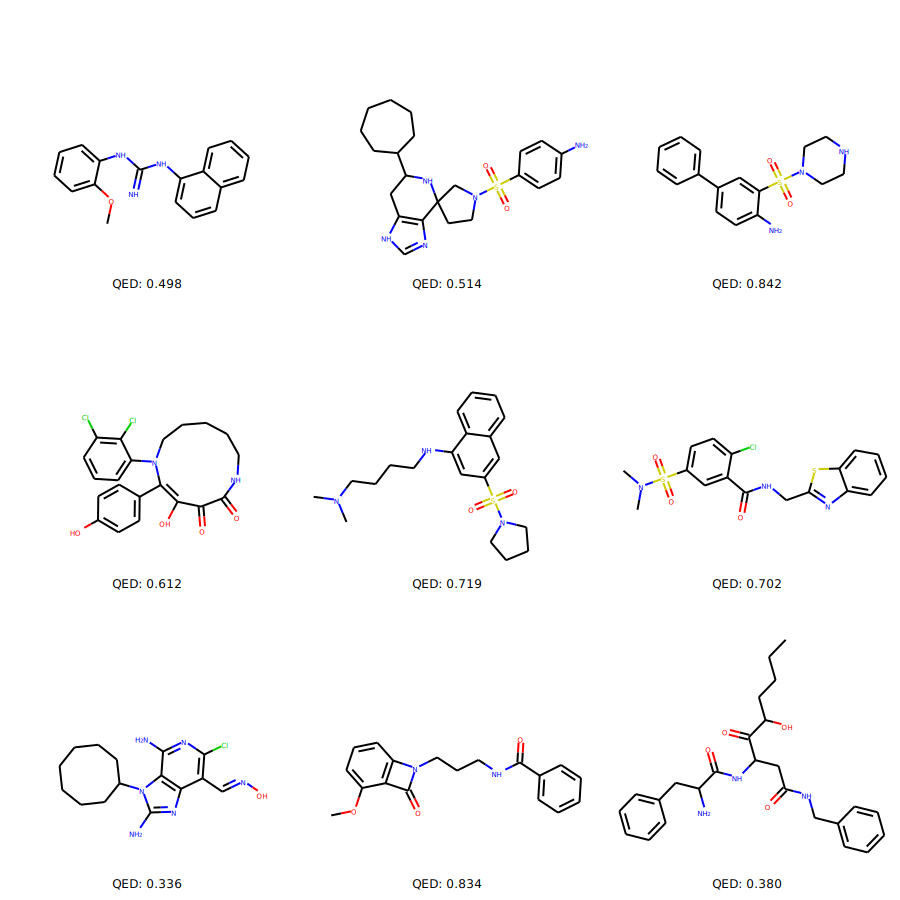

In [0]:
from utils import canonical_smiles
from rdkit.Chem import QED

def generate_smiles(generator, n_to_generate=200):
  generated = []
  pbar = tqdm(range(n_to_generate))
  for i in pbar:
      pbar.set_description("Generating molecules...")
      generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])
    
  sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)
  mols = [Chem.MolFromSmiles(s, sanitize=True) for s in sanitized]
  valid_smiles = [s for s, m in zip(sanitized, mols) if m is not None]
  unique_smiles = list(np.unique(valid_smiles))[1:]

  return unique_smiles, valid_smiles, generated


unique, valid, generated = generate_smiles(my_generator)
novel = [s for s in unique if s not in df[0]]
print(f'valid smiles = {len(valid) / len(generated)}')
print(f'unique smiles = {len(unique) / len(valid)}')
print(f'novel smiles = {len(novel) / len(unique)}')

plot_random_molecules(unique, [f'QED: {QED.qed(Chem.MolFromSmiles(s)):.3f}' for s in unique])

# Molecule Optimization

We can now optimize the generated molecules. We will bias the model to output compounds with boosted properties. To do that, we'll use a simple reinforcement learning algorithm -- policy gradient. Code the predictive part of the model and see how the training process goes. It may happen that the model will generate less valid compounds as the result of learning a new task.

1. Load the pretrained model (or used your own).
2. Implement a predictive model.
3. Propose a reward function.
4. If you are brave enough, you can try to modify the simple policy gradient method.

In [0]:
from stackRNN import StackAugmentedRNN
from reinforcement import Reinforcement

rl_generator = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, 
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, 
                                 has_stack=True, stack_width=stack_width, 
                                 stack_depth=stack_depth, use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

rl_generator.load_model(f'{base_path}/checkpoints/generator/checkpoint_biggest_rnn')

In [0]:
from rdkit.Chem import Crippen

def get_reward(smiles, predictor, invalid_reward=0.0):
  mol, prop, nan_smiles = predictor.predict([smiles])
  if len(nan_smiles) == 1:
    return invalid_reward
  # return calculated reward
  ...

class PropertyPredictor:

  def predict(self, smiles, *args, **kwargs):
    clean_smiles, nan_smiles = [], []
    prop = []
    for s in smiles:
      m = Chem.MolFromSmiles(s)
      if m is None:
        nan_smiles.append(s)
      else:
        try:
          # calculate property
          prop.append(...)
          clean_smiles.append(s)
        except:
          nan_smiles.append(s)
    return clean_smiles, prop, nan_smiles

You can change the policy gradient in this block:

In [0]:
class MyReinforcement(Reinforcement):
  def policy_gradient(self, data, n_batch=10, gamma=0.97,
                        std_smiles=False, grad_clipping=None, **kwargs):
    """
    Implementation of the policy gradient algorithm.
    Parameters:
    -----------
    data: object of type GeneratorData
        stores information about the generator data format such alphabet, etc
    n_batch: int (default 10)
        number of trajectories to sample per batch. When training on GPU
        setting this parameter to to some relatively big numbers can result
        in out of memory error. If you encountered such an error, reduce
        n_batch.
    gamma: float (default 0.97)
        factor by which rewards will be discounted within one trajectory.
        Usually this number will be somewhat close to 1.0.
    std_smiles: bool (default False)
        boolean parameter defining whether the generated trajectories will
        be converted to standardized SMILES before running policy gradient.
        Leave this parameter to the default value if your trajectories are
        not SMILES.
    grad_clipping: float (default None)
        value of the maximum norm of the gradients. If not specified,
        the gradients will not be clipped.
    kwargs: any number of other positional arguments required by the
    Implementation of the policy gradient algorithm.
    Parameters:
    -----------
    data: object of type GeneratorData
        stores information about the generator data format such alphabet, etc
    n_batch: int (default 10)
…        torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 
                                      grad_clipping)

    self.generator.optimizer.step()
    
    return to
        get_reward function.
    Returns
    -------
    total_reward: float
        value of the reward averaged through n_batch sampled trajectories
    rl_loss: float
        value for the policy_gradient loss averaged through n_batch sampled
        trajectories
    """
    rl_loss = 0
    self.generator.optimizer.zero_grad()
    total_reward = 0
    
    for _ in range(n_batch):

        # Sampling new trajectory
        reward = 0
        trajectory = '<>'
        while reward == 0:
            trajectory = self.generator.evaluate(data)
            if std_smiles:
                try:
                    mol = Chem.MolFromSmiles(trajectory[1:-1])
                    trajectory = '<' + Chem.MolToSmiles(mol) + '>'
                    reward = self.get_reward(trajectory[1:-1], 
                                            self.predictor, 
                                            **kwargs)
                except:
                    reward = 0
            else:
                reward = self.get_reward(trajectory[1:-1],
                                        self.predictor, 
                                        **kwargs)

        # Converting string of characters into tensor
        trajectory_input = data.char_tensor(trajectory)
        discounted_reward = reward
        total_reward += reward

        # Initializing the generator's hidden state
        hidden = self.generator.init_hidden()
        if self.generator.has_cell:
            cell = self.generator.init_cell()
            hidden = (hidden, cell)
        if self.generator.has_stack:
            stack = self.generator.init_stack()
        else:
            stack = None

        # "Following" the trajectory and accumulating the loss
        for p in range(len(trajectory)-1):
            output, hidden, stack = self.generator(trajectory_input[p], 
                                                  hidden, 
                                                  stack)
            log_probs = F.log_softmax(output, dim=1)
            top_i = trajectory_input[p+1]
            rl_loss -= (log_probs[0, top_i]*discounted_reward)
            discounted_reward = discounted_reward * gamma

    # Doing backward pass and parameters update
    rl_loss = rl_loss / n_batch
    total_reward = total_reward / n_batch
    rl_loss.backward()
    if grad_clipping is not None:
        torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 
                                      grad_clipping)

    self.generator.optimizer.step()
    
    return total_reward, rl_loss.item()

In [0]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

def simple_moving_average(previous_values, new_value, ma_window_size=10):
  value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
  value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
  return value_ma

predictor = PropertyPredictor()
reinforcer = MyReinforcement(rl_generator, predictor, get_reward)

In [0]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    # plt.axvline(x=0.0)
    # plt.axvline(x=5.0)
    ax.set(xlabel='Predicted Property', 
           title='Distribution of predicted property for generated molecules')
    plt.show()

def estimate_and_update(generator, predictor, n_to_generate):
    '''generates smiles and plots predictions'''
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

In [0]:
from utils import canonical_smiles

_, prediction_unbiased = estimate_and_update(reinforcer.generator, 
                                             predictor, 
                                             n_to_generate)

In [0]:
rewards = []
rl_losses = []

n_iterations = 5

for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = reinforcer.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_biased = estimate_and_update(reinforcer.generator, 
                                                        predictor, 
                                                        n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

### Solution

In [0]:
from rdkit.Chem import Crippen

def get_reward(smiles, predictor, invalid_reward=0.0):
  mol, prop, nan_smiles = predictor.predict([smiles])
  if len(nan_smiles) == 1:
    return invalid_reward
  if (prop[0] >= 1.0) and (prop[0] <= 4.0):
    return 11.0
  else:
    return 1.0

class PropertyPredictor:

  def predict(self, smiles, *args, **kwargs):
    clean_smiles, nan_smiles = [], []
    prop = []
    for s in smiles:
      m = Chem.MolFromSmiles(s)
      if m is None:
        nan_smiles.append(s)
      else:
        try:
          prop.append(Crippen.MolLogP(m))
          clean_smiles.append(s)
        except:
          nan_smiles.append(s)
    return clean_smiles, prop, nan_smiles

# Results

Finally, you can compare your compounds before and after optimization. You can compare the distributions, plot optimized molecules, maybe create a t-SNE map inspired by the maps in the article -- a dimensionality reduction applied to the last layer of the predictive model for the generated compounds.

### Solution

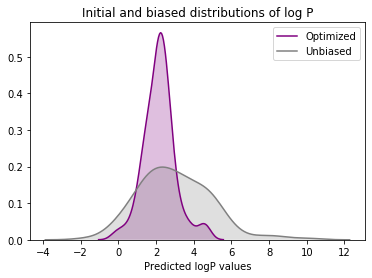

In [23]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted logP values')
plt.title('Initial and biased distributions of log P')
plt.legend()
plt.show()

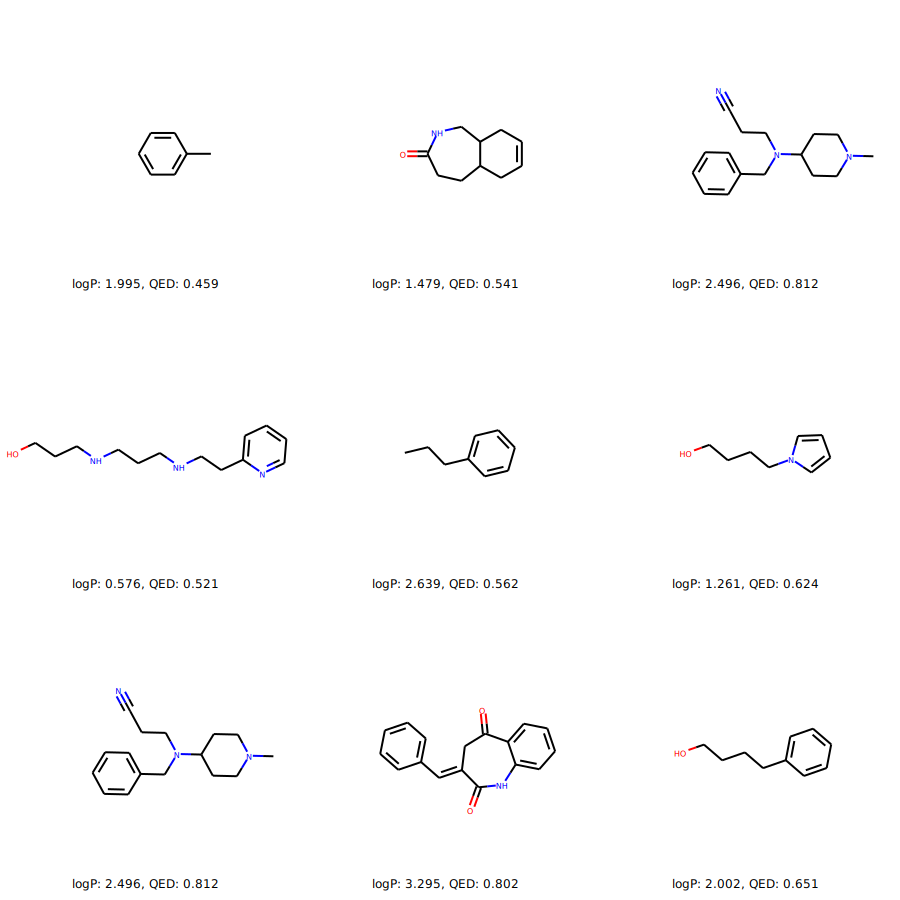

In [28]:
from rdkit.Chem import QED

logps = [f'logP: {Crippen.MolLogP(Chem.MolFromSmiles(s)):.3f}, QED: {QED.qed(Chem.MolFromSmiles(s)):.3f}' for s in smiles_cur]
plot_random_molecules(smiles_cur, logps)